In [40]:
from essentials import *
from IPython.display import Audio
import os

print(device)

cuda


In [41]:
import torchaudio

audio, sr = torchaudio.load('/teamspace/studios/this_studio/moonline.wav')
audio = audio[0][sr:4*sr]

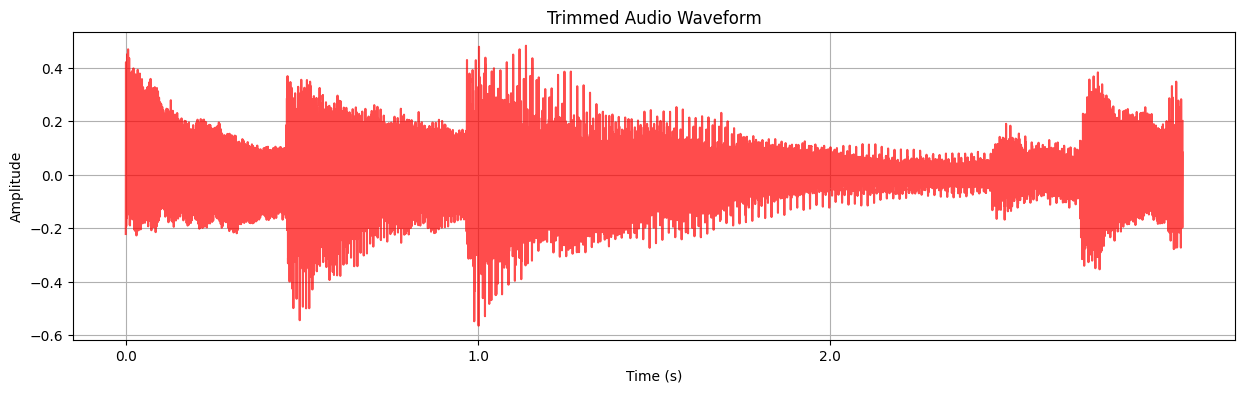

In [42]:
audio_plot(audio, sr, 'red', 'Trimmed Audio Waveform')

### Creating the Time Series $t = [-100.0, \cdots, 100.0]$ domain shifted to $[-100, 100]$

In [43]:
X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
print(X.shape)
print(X)

torch.Size([144000, 1])
tensor([[-100.0000],
        [ -99.9986],
        [ -99.9972],
        ...,
        [  99.9972],
        [  99.9986],
        [ 100.0000]])


In [44]:
Audio(audio, rate=sr)

In [45]:
num_features = 5000
sigma = 0.008

X_rff = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([144000, 5000])
tensor([[ 0.0152, -0.0068, -0.0138,  ...,  0.0168, -0.0033,  0.0192],
        [ 0.0105, -0.0048, -0.0122,  ...,  0.0171, -0.0069,  0.0151],
        [ 0.0049, -0.0027, -0.0106,  ...,  0.0175, -0.0103,  0.0080],
        ...,
        [-0.0097, -0.0077,  0.0189,  ...,  0.0032, -0.0193, -0.0036],
        [-0.0040, -0.0057,  0.0181,  ...,  0.0026, -0.0180, -0.0116],
        [ 0.0021, -0.0036,  0.0172,  ...,  0.0020, -0.0161, -0.0174]],
       device='cuda:0')


In [46]:
import joblib

if os.path.exists('model.pkl'):
    model = joblib.load('model.pkl')
else:
    from sklearn.linear_model import LinearRegression

    model = LinearRegression()
    model.fit(X_rff.cpu().numpy(), audio)
    joblib.dump(model, 'model.pkl')

pred_audio = model.predict(X_rff.cpu().numpy())
print(pred_audio.shape)

(144000,)


In [47]:
np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord=1)

(29.923294, 8741.0205)

## Reconstructed Audio

In [48]:
Audio(pred_audio, rate=sr)

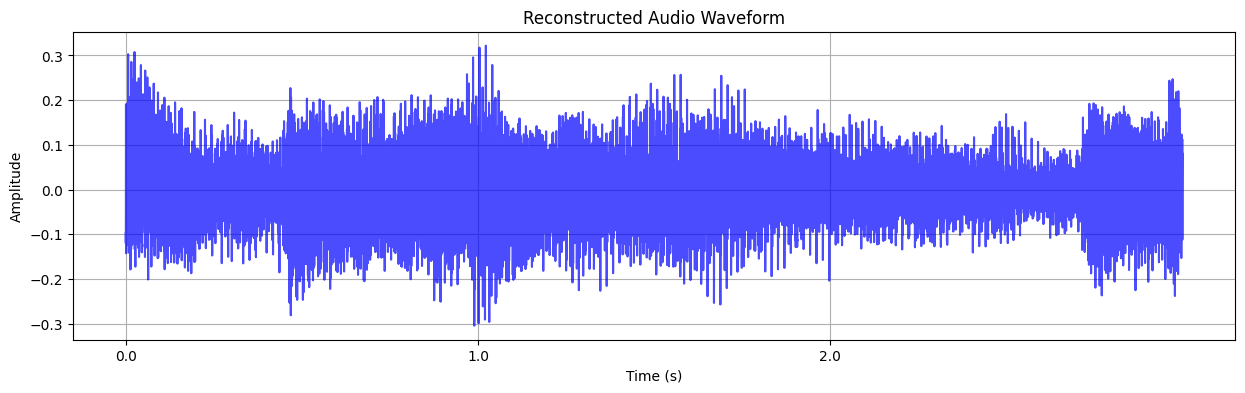

In [49]:
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')

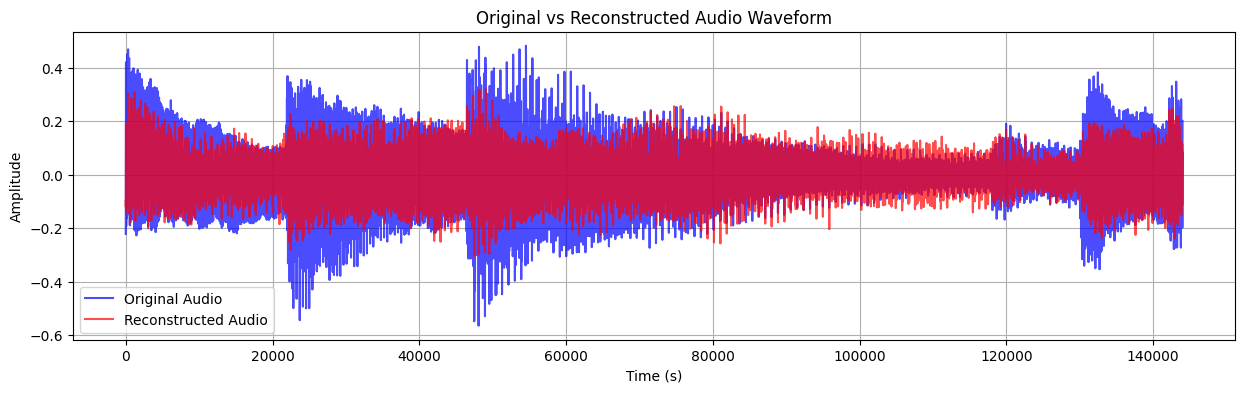

In [50]:
plt.figure(figsize=(15, 4))
plt.plot(audio, color='blue', alpha=0.7, label='Original Audio')
plt.plot(pred_audio, color='red', alpha=0.7, label='Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [52]:
rmse = np.sqrt(np.mean((audio.numpy() - pred_audio) ** 2))
snr = 10 * np.log10(np.mean(audio.numpy() ** 2) / np.mean((audio.numpy() - pred_audio) ** 2))

print(f"RMSE: {rmse}")
print(f"SNR:  {snr} [dB]")

RMSE: 0.07885479927062988
SNR:  2.7793779969215393 [dB]
